In [10]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

# Load Database

In [2]:
conn = sqlite3.connect('Data/HMTG_possib_remote.db')
dat = pd.read_sql_query('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.bonus NOTNULL', conn)
dat = dat.astype({'trl': int})


## Cleaning
### Make sure all subjects have 45 trials. group by trustee observed

In [3]:
# Drop any subject with less than 45 trials
for trustee in dat.trustee_id.unique():
    for subject in dat.loc[dat.trustee_id == trustee].subject_id.unique():
        if dat.loc[dat.subject_id==subject].trl.max() != 44:
            dat.drop(dat.index[dat['subject_id'] == subject], inplace=True)

sub_count = dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))
sub_count

,subject_id
trustee_id,
54,19
62,19
93,24
97,13


### Add column for trustee strategy

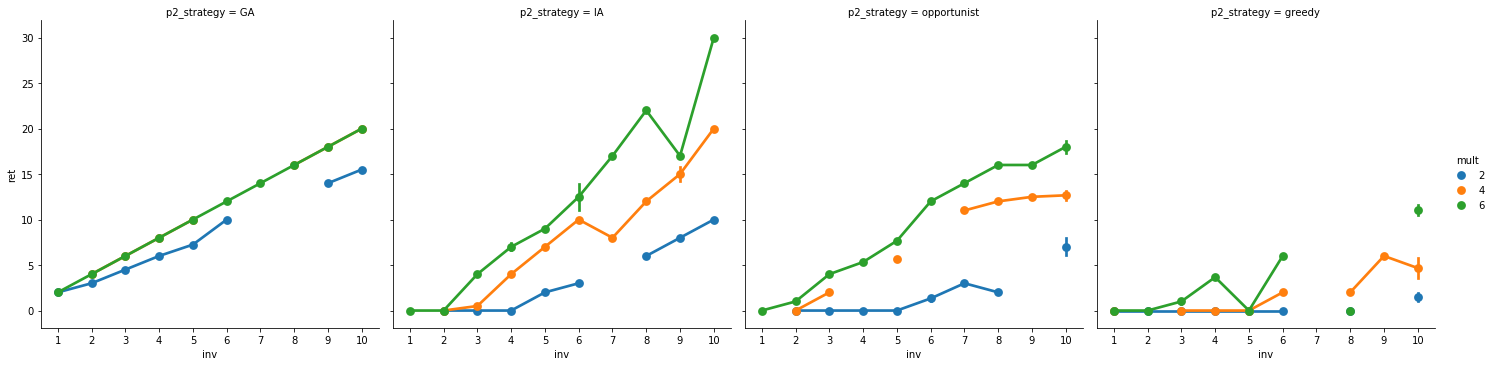

In [4]:
# Add Trustee Strategy
p2s = {54:'opportunist', 62:'greedy', 93:'GA', 97:'IA'}
dat['p2_strategy'] = dat.trustee_id.apply(lambda x: p2s[x])
#sns.catplot(x='inv', y='ret', hue='mult', data=dat, col='p2_strategy', kind='point')

### Make sure each trustee was observed by the same number of subject

In [5]:
# Ensure that each trustee was viewed by the same amount of subjects
n = sub_count.subject_id.min()

for trustee in dat.trustee_id.unique():
    subs_x_trustee = len(dat.loc[dat.trustee_id == trustee].subject_id.unique()) # number of subjects who viewed a single trustee
    if subs_x_trustee != n:
        indx2drop = np.random.choice(range(subs_x_trustee), size=(subs_x_trustee-n), replace=False) #pick random indices to drop
        subs2drop = dat.loc[dat.trustee_id == trustee].subject_id.unique()[indx2drop]  #find the subjects corresponding to random indices

        [dat.drop(dat.index[dat['subject_id'] == ss], inplace=True) for ss in subs2drop] # drop extras
dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))

# Compute and Plot Prediction Errors

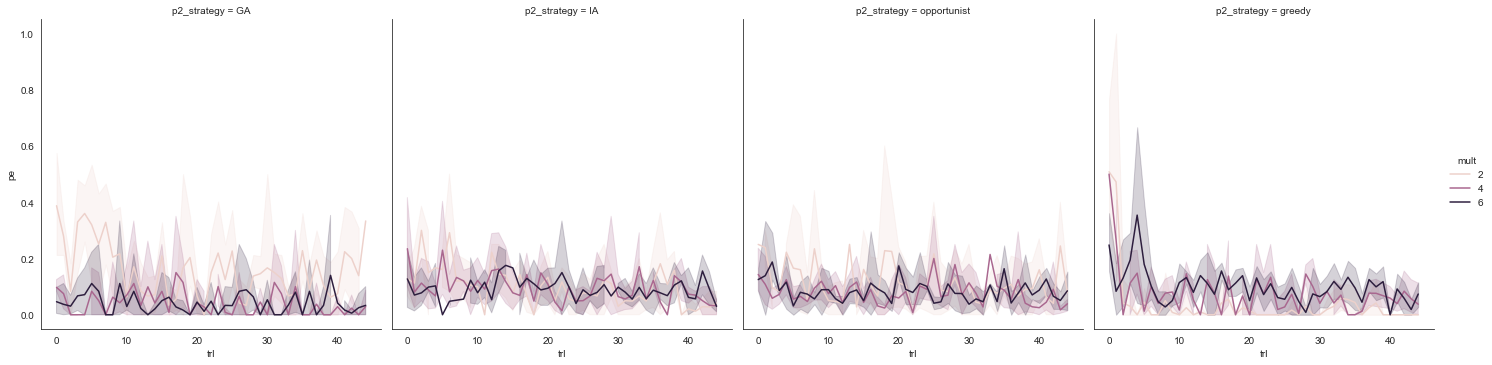

In [11]:
# Make errors between 0 and 1
dat['pe'] = abs((dat.pred/(dat.mult*dat.inv)) - (dat.ret/(dat.mult*dat.inv)))
sns.relplot(x='trl', y='pe', data=dat, hue='mult', col='p2_strategy', kind='line')


# Make sure probes evenly spaced

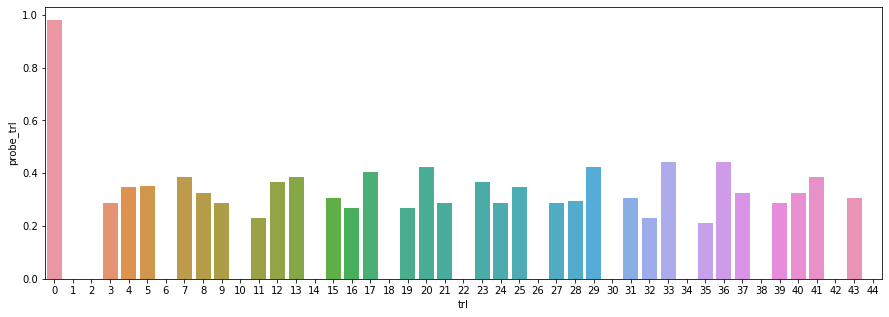

In [8]:
dat['probe_trl'] = dat.reason != 'n/a'
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=dat, x='trl', y='probe_trl', ci=None)

# Let's try NLP stuff FML

In [13]:
#import tensorflow as tf
!pwd

/Users/bryangonzalez/PycharmProjects/HMTG_possibilities/analysis/Experiment_1


In [48]:
#from absl-py import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)


ModuleNotFoundError: No module named 'tensorflow'

In [49]:
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
#logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

NameError: name 'embed' is not defined